<a href="https://colab.research.google.com/github/PriyaJ28/Spam_classification-with-BERT-and-Pytorch/blob/master/Bert_and_Pytorch_Spam_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

device = torch.device("cuda")

## **Load Dataset**

In [5]:
df = pd.read_csv("/content/spam.csv")
print(df.head())
print(df.shape)

   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
(5572, 2)


In [6]:
#checking the class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [7]:
x_train, x_rest, y_train, y_rest = train_test_split(df['text'], df['label'], 
                                                                    random_state=2020, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, 
                                                                random_state=2020, 
                                                                test_size=0.5, 
                                                                stratify=y_rest)

## **Import BERT Model and Tokenizer**

In [8]:
#importing BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

#Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [9]:
#Sample data 
text = ["This is an Data Science internship task", "for fine tuning bert model"]

#encode data
out = tokenizer.batch_encode_plus(text, padding = True, return_token_type_ids= False)

#printing
print(out)

{'input_ids': [[101, 2023, 2003, 2019, 2951, 2671, 22676, 4708, 102], [101, 2005, 2986, 17372, 14324, 2944, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0]]}


# **Tokenization**

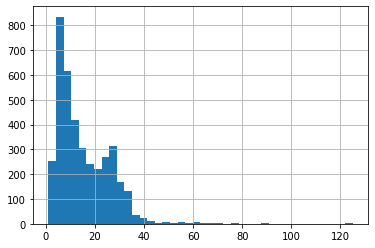

In [10]:
#finding the lengths of all the training texts

length_of_sequence = [len(i.split()) for i in x_train]
pd.Series(length_of_sequence).hist(bins = 40)

As we can see most of the data has length less than 30 so we'll set our maximum length of the sequence as 30

In [11]:
max_len = 30

In [12]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
                                            x_train.tolist(),
                                            max_length = max_len,
                                            pad_to_max_length=True,
                                            truncation=True,
                                            return_token_type_ids=False
                                          )

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
                                            x_val.tolist(),
                                            max_length = max_len,
                                            pad_to_max_length=True,
                                            truncation=True,
                                            return_token_type_ids=False
                                        )

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
                                            x_test.tolist(),
                                            max_length = max_len,
                                            pad_to_max_length=True,
                                            truncation=True,
                                            return_token_type_ids=False
                                          )

## **Convert Integer Sequences to Tensors**

In [13]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

# **Create DataLoaders**

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# **Freeze BERT Parameters**

In [15]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## **Define Model Architecture**

In [16]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [17]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

## **Dealing with unbalaced classes**

In [18]:
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight('balanced', np.unique(y_train), y_train)

print(class_wts)

[0.57743559 3.72848948]


In [19]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 20

# **Fine-Tune BERT**

In [20]:
def train():

  model.train()

  total_loss = 0
  
  #model predictions
  prediction = []

  #iterate over batches
  for iter, batch in enumerate(train_dataloader):

    if iter%50==0 and not iter==0:
       print('  Batch {:>5,}  of  {:>5,}.'.format(iter, len(train_dataloader)))

    #push the batch to gpu
    batch = [i.to(device) for i in batch]

    sent_id, mask, labels = batch

    #zero out previous gradients
    model.zero_grad()

    pred = model(sent_id, mask)

    #loss
    loss = cross_entropy(pred, labels)

    total_loss+=loss

    #backward pass to calculate gradients
    loss.backward()

    #clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
 
    #optimizer updating parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    pred=pred.detach().cpu().numpy()

    #append the model pred to list
    prediction.append(pred)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  prediction = np.concatenate(prediction , axis=0)

  #returns the loss and predictions
  return avg_loss, prediction


In [21]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss= 0
  
  # empty list to save the model predictions
  prediction = []

  # iterate over batches
  for iter,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if iter % 50 == 0 and not iter == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(iter, len(val_dataloader)))

    # push the batch to gpu
    batch = [i.to(device) for i in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      pred = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(pred,labels)

      total_loss = total_loss + loss.item()

      pred = pred.detach().cpu().numpy()

      prediction.append(pred)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  prediction = np.concatenate(prediction , axis=0)

  return avg_loss, prediction

# **Model Training**

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

In [23]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# **Predictions**

In [24]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       724
           1       0.83      0.95      0.88       112

    accuracy                           0.97       836
   macro avg       0.91      0.96      0.93       836
weighted avg       0.97      0.97      0.97       836

